In [62]:
# imports
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import missingno as msno
import pickle



import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, IsolationForest,
                              RandomForestRegressor, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier)
from sklearn.linear_model import Perceptron


# Performance metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

import warnings
warnings.filterwarnings('ignore')


In [2]:
#Get Exo-Planet file and load it into pandas DataFrame
file_name = 'data\\exoplanet_data'


hec_file_name = 'data\\phl_exoplanet_catalog'
input_dir = os.getcwd()
exoplanet_file = os.path.join(input_dir, file_name + '.csv')
hec_file = os.path.join(input_dir,hec_file_name + '.csv')


#hecfile
hec = pd.read_csv(hec_file)

#DataFrame
df = pd.read_csv (exoplanet_file)
df = df[df["default_flag"] == 1]
df = df.reset_index()
# df=df.dropna()
df.head()

,index,planet_name,hostname,default_flag,number_of_stars,number_of_planets,planet_orbital_period,orbit_semimajor_axis,planet_radius,planet_mass,planet_equillirium_temperature,star_spectype,stellar_temperature,stellar_radius,stellar_mass,stellar_age,system_distance
0,0,11 Com b,11 Com,1,2,1,326.03000,1.29,NaN,NaN,NaN,G8 III,4742.0,19.00,2.70,NaN,93.1846
1,3,11 UMi b,11 UMi,1,1,1,516.21997,1.53,NaN,NaN,NaN,NaN,4213.0,29.79,2.78,NaN,125.3210
2,6,14 And b,14 And,1,1,1,185.84000,0.83,NaN,NaN,NaN,K0 III,4813.0,11.00,2.20,NaN,75.4392
3,12,14 Her b,14 Her,1,1,2,1773.40002,2.93,NaN,NaN,NaN,NaN,5338.0,0.93,0.90,NaN,17.9323
4,15,16 Cyg B b,16 Cyg B,1,3,1,798.50000,1.66,NaN,NaN,NaN,NaN,5750.0,1.13,1.08,NaN,21.1397


In [3]:
# Check total dataset
print("Total exoplanets in the Dataset are",df.shape[0])


Total exoplanets in the Dataset are 4569


### Classification on the number of host stars

In [4]:
# unary_system = df[df["number_of_stars"]== 1]
# total_unary_system = unary_system.shape[0]

# binary_system

stars = df.value_counts('number_of_stars')
stars

number_of_stars
1    4124
2     390
3      53
4       2
dtype: int64

In [5]:
planets = df.value_counts('number_of_planets')
planets

number_of_planets
1    2600
2    1042
3     495
4     244
5     125
6      48
8       8
7       7
dtype: int64

In [6]:
spec_type = df.value_counts('star_spectype')
spec_type

star_spectype
G0 V        41
K2 V        29
K0 V        23
F8 V        23
G5 V        22
            ..
K1.5 III     1
F6 IV-V      1
M1 III       1
F5 IV        1
m3 V         1
Length: 180, dtype: int64

<AxesSubplot:>

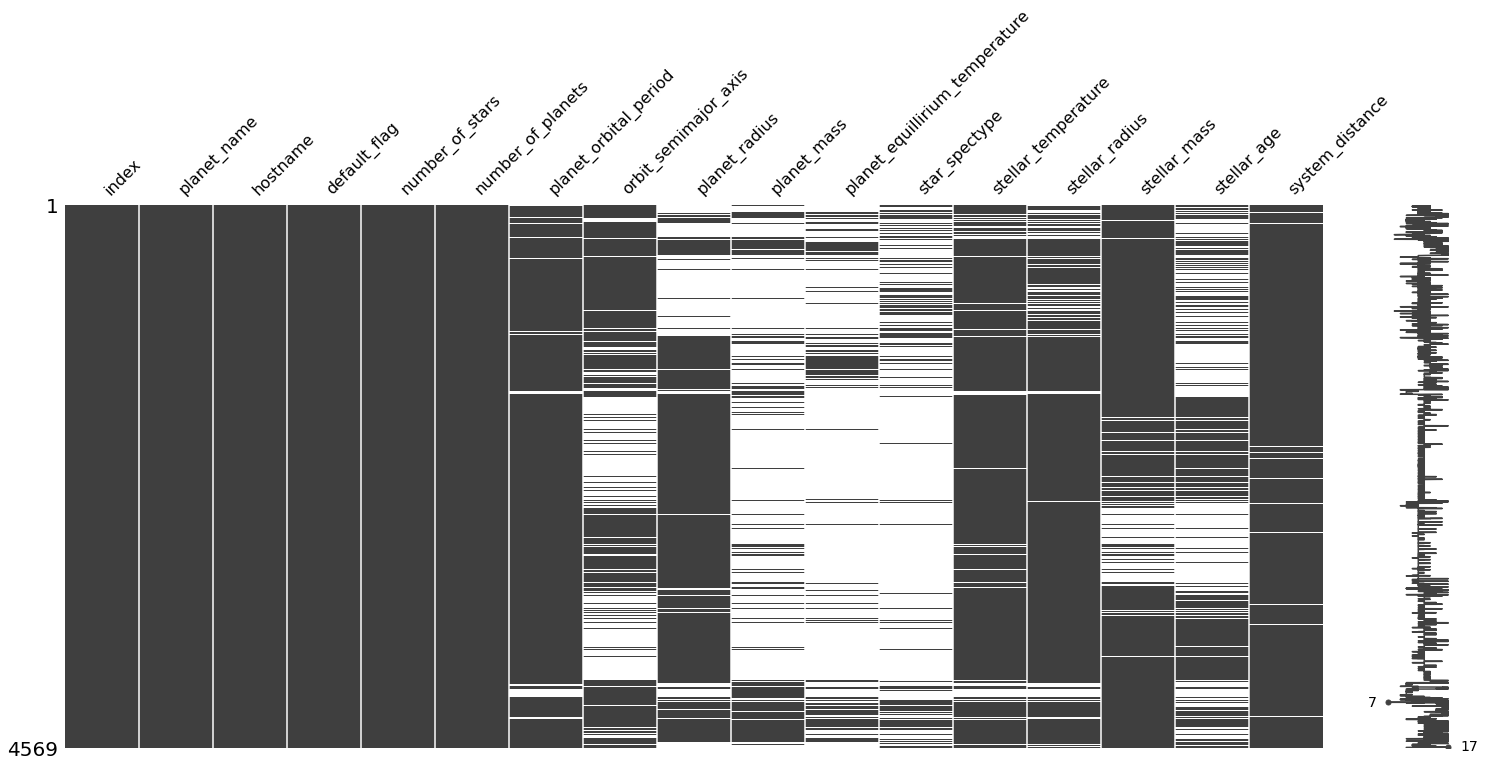

In [7]:
msno.matrix(df)
# white indicates missing data

In [8]:
hec.head()

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007,2014-05-14,...,0,Hot,0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.86330,1.29
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009,2018-09-06,...,0,Hot,0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.78480,1.53
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008,2014-05-14,...,0,Hot,0,0.081917,Andromeda,And,Andromeda,12.848516,1525.57440,0.83
3,14 Her b,3.0,1481.07850,-47.67420,47.67420,NaN,NaN,NaN,2002,2018-09-06,...,0,Cold,0,0.145241,Hercules,Her,Hercules,12.865261,1481.07850,2.93
4,16 Cyg B b,3.0,565.73385,-25.42624,25.42624,NaN,NaN,NaN,1996,2018-09-06,...,1,Warm,0,0.368627,Cygnus,Cyg,Swan,13.421749,565.73385,1.66


In [9]:
target_count = hec['P_HABITABLE'].value_counts()
'''
0 --> not habitable
1 --> conservative
2 --> optimistic
'''
target_count

0    3993
2      34
1      21
Name: P_HABITABLE, dtype: int64

In [10]:
# drop not habitable planets
hec = hec[hec.P_HABITABLE != 0]

In [11]:
# create habitable column for planets data with the help of hec dataframe
# get names of planets

habitable_planets = hec.P_NAME.values
df['habitable'] = df['planet_name'].isin(habitable_planets)

In [12]:
target_count = df['habitable'].value_counts()
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')
print(f'Percentage of Minority Class: {round(target_count[1] / sum(target_count), 4)*100}')

Class 0: 4515
Class 1: 54
Percentage of Majority Class: 98.82
Percentage of Minority Class: 1.18


### Handling Missing Data

In [13]:
# remove columns with more than 40% missing data
def remove_missing(f):
    count = len(df[df[f].isnull()])
    if count/len(df) > 0.4:
        return 1
    else:
        return 0

missing_values = [x for x in df.columns if remove_missing(x)]
df = df.drop(missing_values, axis=1)

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.ensemble import RandomForestRegressor

# IterativeImputer
# get only numeric values
numeric_values = df[df._get_numeric_data().columns]
imp = IterativeImputer(RandomForestRegressor(), max_iter=10, random_state=76)
numeric_values = pd.DataFrame(imp.fit_transform(numeric_values), columns=numeric_values.columns)
numeric_values.to_csv('Imputed Data.csv', index='rowid')

In [15]:
imputed_numerics = pd.read_csv('data/Imputed Data.csv')

In [16]:
# merge imputed data with the planets dataframe
for i in imputed_numerics.columns:
    if i not in df.columns:
        pass
    else:
        df[i] = imputed_numerics[i]

<AxesSubplot:>

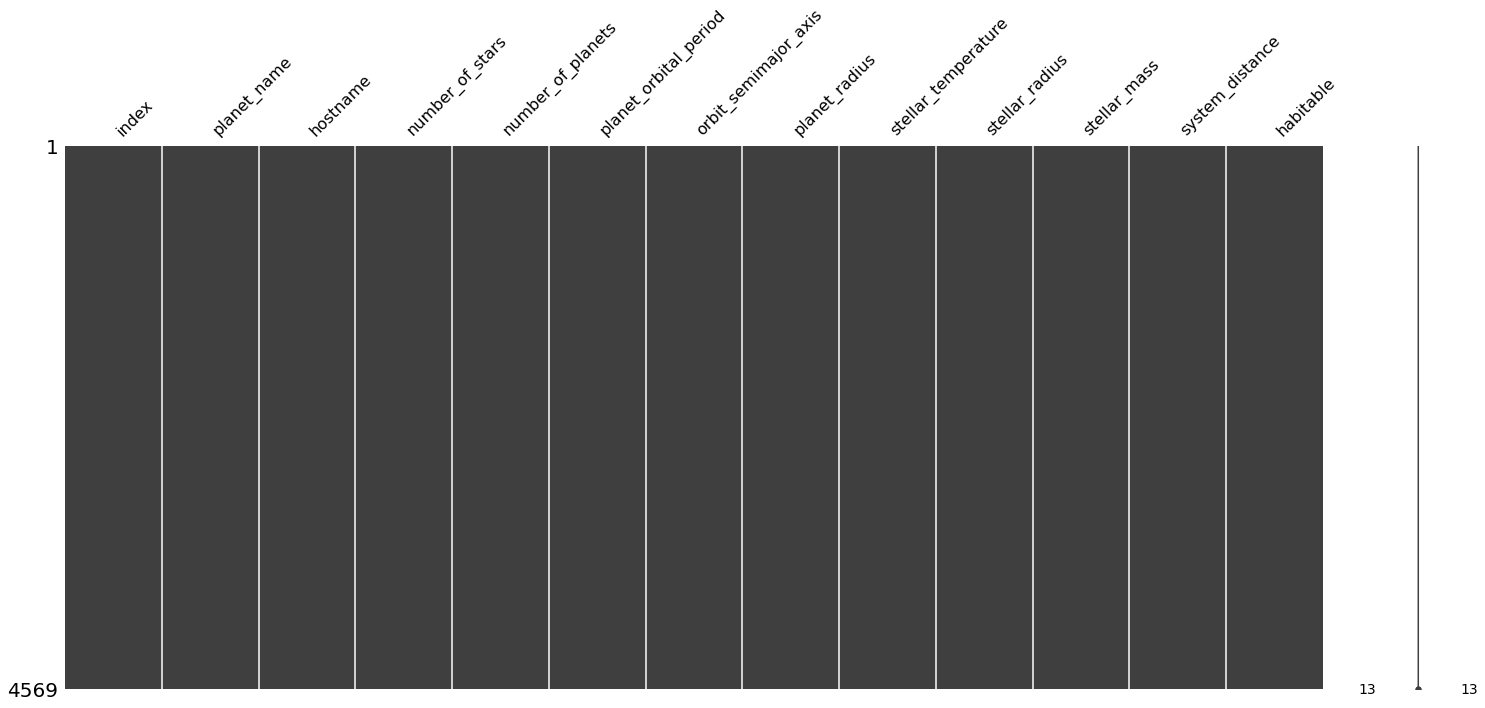

In [17]:
# also drop these columns too since they are useless to modeling
cols_to_drop = ['default_flag']

df = df.drop(cols_to_drop, axis=1)


msno.matrix(df)

In [18]:
df

,index,planet_name,hostname,number_of_stars,number_of_planets,planet_orbital_period,orbit_semimajor_axis,planet_radius,stellar_temperature,stellar_radius,stellar_mass,system_distance,habitable
0,0.0,11 Com b,11 Com,2.0,1.0,326.030000,1.290000,14.02644,4742.0000,19.00,2.70,93.1846,0.0
1,3.0,11 UMi b,11 UMi,1.0,1.0,516.219970,1.530000,14.78741,4213.0000,29.79,2.78,125.3210,0.0
2,6.0,14 And b,14 And,1.0,1.0,185.840000,0.830000,13.37516,4813.0000,11.00,2.20,75.4392,0.0
3,12.0,14 Her b,14 Her,1.0,2.0,1773.400020,2.930000,5.13886,5338.0000,0.93,0.90,17.9323,0.0
4,15.0,16 Cyg B b,16 Cyg B,3.0,1.0,798.500000,1.660000,8.45273,5750.0000,1.13,1.08,21.1397,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4564,29580.0,tau Gem b,tau Gem,1.0,1.0,305.500000,1.170000,14.61674,4388.0000,26.80,2.30,112.5370,0.0
4565,29588.0,ups And b,ups And,2.0,3.0,4.617033,0.059222,6.44500,6279.6242,1.56,1.30,13.4054,0.0
4566,29590.0,ups And c,ups And,2.0,3.0,241.258000,0.827774,6.52678,6258.6534,1.56,1.30,13.4054,0.0
4567,29598.0,ups And d,ups And,2.0,3.0,1276.460000,2.513290,6.52678,6238.3519,1.56,1.30,13.4054,0.0


In [19]:
# Any missing values?
print(df.isnull().values.any())


False


###  Part 2: Visualization & EDA

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4569 entries, 0 to 4568
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  4569 non-null   float64
 1   planet_name            4569 non-null   object 
 2   hostname               4569 non-null   object 
 3   number_of_stars        4569 non-null   float64
 4   number_of_planets      4569 non-null   float64
 5   planet_orbital_period  4569 non-null   float64
 6   orbit_semimajor_axis   4569 non-null   float64
 7   planet_radius          4569 non-null   float64
 8   stellar_temperature    4569 non-null   float64
 9   stellar_radius         4569 non-null   float64
 10  stellar_mass           4569 non-null   float64
 11  system_distance        4569 non-null   float64
 12  habitable              4569 non-null   float64
dtypes: float64(11), object(2)
memory usage: 464.2+ KB


Text(0.5, 1.0, 'Temperature - Mass Relation with Habitability')

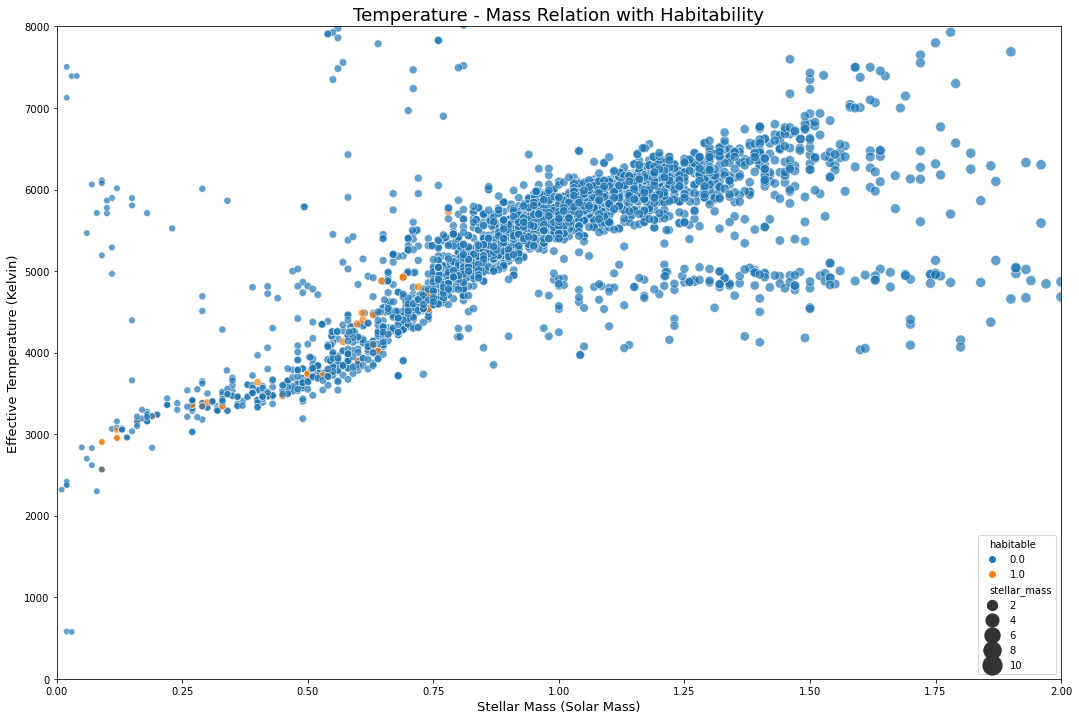

In [21]:
plt.figure(figsize=(18, 12))
ax = sns.scatterplot(x='stellar_mass', y='stellar_temperature',
                     hue='habitable', size='stellar_mass',
                     sizes=(40, 400), alpha=.7,
                     data=df)
# limiting x and y axis's values
ax.axis([0,2, 0, 8000])
ax.set_xlabel('Stellar Mass (Solar Mass)', fontsize=13)
ax.set_ylabel('Effective Temperature (Kelvin)', fontsize=13)
ax.set_title('Temperature - Mass Relation with Habitability', fontsize=18)



In [22]:
corr_mtrx = df.corr()
corr_df = pd.DataFrame(corr_mtrx['habitable'].sort_values(ascending=False))
corr_df.head(10)

,habitable
habitable,1.000000
number_of_planets,0.092722
number_of_stars,0.034946
index,0.009867
planet_orbital_period,-0.002215
orbit_semimajor_axis,-0.004914
stellar_radius,-0.029794
system_distance,-0.048643
planet_radius,-0.061543
stellar_temperature,-0.086056


### Distance - Travel Time

In [23]:
planets_c = df[['system_distance', 'habitable', 'stellar_mass']]
planets_c.drop(planets_c[planets_c.habitable != 1].index, inplace=True)

In [24]:


planets_c['dist_to_star_ly'] = planets_c['system_distance'] * 3.26
"""
The Voyager 1 spacecraft is on an interstellar mission. It is traveling away from the Sun at a rate of 17.3 km/s. It means
62280 km/h. 
1 light year = 9.4605284 × 10^12 kilometers
1 year = 8760 hours
1 speed of light = 1079252848.8 km/h
""" 
planets_c['minimum_travel_time_year'] = (((planets_c['dist_to_star_ly'] * 9.461e12) / 62280) / 8760)
planets_c.head()



,system_distance,habitable,stellar_mass,dist_to_star_ly,minimum_travel_time_year
168,3.672780,1.0,0.1200,11.973263,2.076332e+05
169,3.672780,1.0,0.1200,11.973263,2.076332e+05
183,15.128500,1.0,1.0583,49.318910,8.552593e+05
194,5.921535,1.0,0.2900,19.304204,3.347621e+05
206,20.190300,1.0,0.4200,65.820378,1.141418e+06


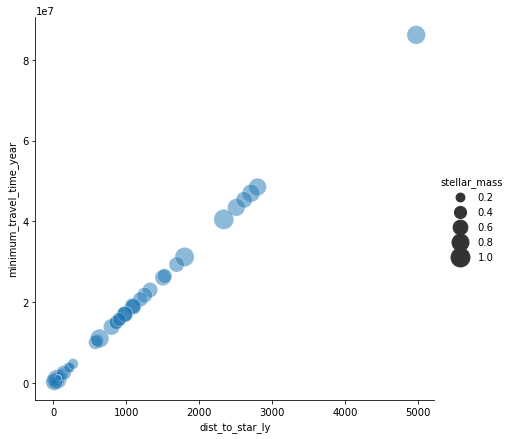

In [25]:
sns.relplot(x="dist_to_star_ly", y="minimum_travel_time_year", size="stellar_mass",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=planets_c)

### Part 3: Heading to Machine Learning

In [26]:
planets_df = df.copy()

In [27]:
cols_to_drop = ['index','planet_name','hostname','system_distance']
planets_df = planets_df.drop(cols_to_drop, axis=1)


planets_df

,number_of_stars,number_of_planets,planet_orbital_period,orbit_semimajor_axis,planet_radius,stellar_temperature,stellar_radius,stellar_mass,habitable
0,2.0,1.0,326.030000,1.290000,14.02644,4742.0000,19.00,2.70,0.0
1,1.0,1.0,516.219970,1.530000,14.78741,4213.0000,29.79,2.78,0.0
2,1.0,1.0,185.840000,0.830000,13.37516,4813.0000,11.00,2.20,0.0
3,1.0,2.0,1773.400020,2.930000,5.13886,5338.0000,0.93,0.90,0.0
4,3.0,1.0,798.500000,1.660000,8.45273,5750.0000,1.13,1.08,0.0
...,...,...,...,...,...,...,...,...,...
4564,1.0,1.0,305.500000,1.170000,14.61674,4388.0000,26.80,2.30,0.0
4565,2.0,3.0,4.617033,0.059222,6.44500,6279.6242,1.56,1.30,0.0
4566,2.0,3.0,241.258000,0.827774,6.52678,6258.6534,1.56,1.30,0.0
4567,2.0,3.0,1276.460000,2.513290,6.52678,6238.3519,1.56,1.30,0.0


### SMOTE - Over Sampling

In [28]:
# Basic validation: splitting the data 60 - 20 - 20 train/val/test
X_train, X_test, y_train, y_test = train_test_split(planets_df.iloc[:, :-1], planets_df.loc[:, 'habitable'], test_size=0.25,random_state=76)
X_train.shape # shape of my train set

(3426, 8)

In [29]:
# Resampling imbalanced data
from imblearn.over_sampling import SMOTE

X_smoted, y_smoted = SMOTE(sampling_strategy='minority', random_state=76).fit_resample(X_train, y_train)

In [30]:
X_smoted.shape

(6766, 8)

<AxesSubplot:>

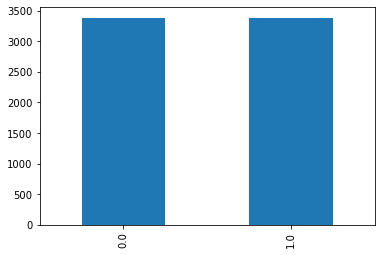

In [31]:
# observe that data has been balanced
pd.Series(y_smoted).value_counts().plot.bar()

### Machine Learning Models

In [32]:
# list to contain model and accuracy values
eva_list = []
# to contain model names
models = []

### Logistic Regression

In [33]:
lr = LogisticRegression()
lr.fit(X_smoted, y_smoted)
y_pred_l = lr.predict(X_test)

lr_acc = round(lr.score(X_smoted, y_smoted) * 100, 2)
lr_acc_test = round(accuracy_score(y_test, y_pred_l) * 100, 2)
print(f'Train Accuracy of Logistic Regression: % {lr_acc}')
print(f'Test Accuracy of Logistic Regression: % {lr_acc_test}')

# Get precision, recall, and f1
precision, recall, f1, support = score(y_test, y_pred_l, average = 'macro')
print(f'Precision : {precision}')
print(f'Recall : {recall}')
print(f'F1-score : {f1}')

Train Accuracy of Logistic Regression: % 82.8
Test Accuracy of Logistic Regression: % 81.36
Precision : 0.5193711218359106
Recall : 0.8158930292322519
F1-score : 0.4871362214427908


In [34]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'Logistic Regression'),
    ('Train Accuracy', round(lr_acc, 2)),
    ('Test Accuracy', round(lr_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### Linear SVC

In [35]:
# svc = SVC(kernel='linear', gamma=0.001, C=100, probability=True)
# svc.fit(X_smoted, y_smoted)
# y_pred_s = svc.predict(X_test)

# svc_acc = round(svc.score(X_smoted, y_smoted) * 100, 2)
# svc_acc_test = round(accuracy_score(y_test, y_pred_s) * 100, 2)

# print(f'Train Accuracy Score of LinearSVC: % {svc_acc}')
# print(f'Test Accuracy Score of LinearSVC: % {svc_acc_test}')

# # Get precision, recall, f1 scores
# precision, recall, f1, support = score(y_test, y_pred_s, average='macro')
# print(f'Precision : {precision}')
# print(f'Recall    : {recall}')
# print(f'F1-score   : {f1}')

In [36]:


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_smoted, y_smoted)
y_pred = knn.predict(X_test)

knn_acc = round(knn.score(X_smoted, y_smoted) * 100, 2)
knn_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy of KNN: % {knn_acc}')
print(f'Test Accuracy of KNN: % {knn_acc_test}')

# Get precision, recall, and f1
precision, recall, f1, support = score(y_test, y_pred, average = 'macro')
print(f'Precision : {precision}')
print(f'Recall : {recall}')
print(f'F1-score : {f1}')



Train Accuracy of KNN: % 98.15
Test Accuracy of KNN: % 95.36
Precision : 0.5675830287621166
Recall : 0.8415515579826534
F1-score : 0.6039889392245691


In [37]:
eva_list.append(dict([
    ('Model', 'K-Nearest Neighbors'),
    ('Train Accuracy', round(knn_acc, 2)),
    ('Test Accuracy', round(knn_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### Naive Bayes

In [38]:
nbg = GaussianNB()
nbg.fit(X_smoted, y_smoted)
y_pred_n = nbg.predict(X_test)

nbg_acc=round(nbg.score(X_smoted, y_smoted) * 100, 2)
nbg_acc_test=round(accuracy_score(y_test, y_pred_n) * 100, 2)

print(f'Train Accuracy Score of GaussianNB: % {nbg_acc}')
print(f'Test Accuracy Score of GaussianNB: % {nbg_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred_n, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of GaussianNB: % 54.69
Test Accuracy Score of GaussianNB: % 10.24
Precision : 0.5053037608486017
Recall    : 0.5468197879858657
F1-score   : 0.09611815412694694


In [40]:
eva_list.append(dict([
    ('Model', 'Gaussian Naive Bayes'),
    ('Train Accuracy', round(nbg_acc, 2)),
    ('Test Accuracy', round(nbg_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### Decision Trees

In [41]:
dt = DecisionTreeClassifier()
dt.fit(X_smoted, y_smoted)
y_pred = dt.predict(X_test)

dt_acc = round(dt.score(X_smoted, y_smoted) * 100, 2)
dt_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy Score of Decision Trees: % {dt_acc}')
print(f'Test Accuracy Score of Decision Trees: % {dt_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Decision Trees: % 100.0
Test Accuracy Score of Decision Trees: % 97.99
Precision : 0.5797777777777778
Recall    : 0.6297381946675233
F1-score   : 0.5983530166684492


In [44]:
eva_list.append(dict([
    ('Model', 'Decision Trees'),
    ('Train Accuracy', round(dt_acc, 2)),
    ('Test Accuracy', round(dt_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

In [45]:
# View feature importances
importances_dt = pd.DataFrame({'feature': X_train.columns,
                             'importance': dt.feature_importances_})
importances_dt = importances_dt.sort_values('importance',ascending=False).set_index('feature')
importances_dt

,importance
feature,
stellar_radius,0.388436
planet_orbital_period,0.335720
planet_radius,0.196890
number_of_planets,0.037799
stellar_mass,0.016855
orbit_semimajor_axis,0.015560
stellar_temperature,0.005985
number_of_stars,0.002755


### Random Forest

In [46]:
num_estimator = 100
seed = 7
rf = RandomForestClassifier(n_estimators=num_estimator)
rf.fit(X_smoted, y_smoted)
y_predr = rf.predict(X_test)

rf_acc = round(rf.score(X_smoted, y_smoted) * 100, 2)
rf_acc_test = round(accuracy_score(y_test, y_predr) * 100, 2)
print(f'Train Accuracy Score of Random Forest: % {rf_acc}')
print(f'Test Accuracy Score of Random Forest: % {rf_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_predr, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Random Forest: % 100.0
Test Accuracy Score of Random Forest: % 98.34
Precision : 0.6362222222222222
Recall    : 0.7215306778027626
F1-score   : 0.6682046659435015


In [47]:
eva_list.append(dict([
    ('Model', 'Random Forest'),
    ('Train Accuracy', round(rf_acc, 2)),
    ('Test Accuracy', round(rf_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

In [48]:
# View feature importances
importances_rf = pd.DataFrame({'feature': X_train.columns,
                             'importance': rf.feature_importances_})
importances_rf = importances_rf.sort_values('importance',ascending=False).set_index('feature')
importances_rf

,importance
feature,
planet_orbital_period,0.204972
stellar_radius,0.175875
orbit_semimajor_axis,0.156851
stellar_mass,0.155402
stellar_temperature,0.136623
planet_radius,0.110766
number_of_planets,0.054203
number_of_stars,0.005309


### Stochastic Gradient Boosting Classifier

In [49]:
gbc = GradientBoostingClassifier(n_estimators=num_estimator, learning_rate=0.01,
                                random_state=seed)
gbc.fit(X_smoted, y_smoted)
y_pred_g = gbc.predict(X_test)

gbc_acc = round(gbc.score(X_smoted, y_smoted) * 100, 2)
gbc_acc_test = round(accuracy_score(y_test, y_pred_g) * 100, 2)
print(f'Train Accuracy Score of Gradient Boosting: % {gbc_acc}')
print(f'Test Accuracy Score of Gradient Boosting: % {gbc_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred_g, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Gradient Boosting: % 96.11
Test Accuracy Score of Gradient Boosting: % 91.86
Precision : 0.5393809198320477
Recall    : 0.8238837134596853
F1-score   : 0.5520348261432069


In [50]:
eva_list.append(dict([
    ('Model', 'Stochastic Gradient Boosting Classifier'),
    ('Train Accuracy', round(gbc_acc, 2)),
    ('Test Accuracy', round(gbc_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### AdaBoost Classifier

In [51]:
abc = AdaBoostClassifier(base_estimator=rf, n_estimators=num_estimator, random_state = seed)
abc.fit(X_smoted, y_smoted)
y_pred = abc.predict(X_test)

abc_acc = round(abc.score(X_smoted, y_smoted) *100 , 2)
abc_acc_test = round(accuracy_score(y_test, y_pred) * 100 ,2)

print(f'Train Accuracy Score of AdaBoostClassifier: % {abc_acc}')
print(f'Test Accuracy Score of AdaBoostClassifier: % {abc_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1score, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1score}')

Train Accuracy Score of AdaBoostClassifier: % 100.0
Test Accuracy Score of AdaBoostClassifier: % 98.25
Precision : 0.5964539007092199
Recall    : 0.631063283006746
F1-score   : 0.6109598366235535


In [52]:
eva_list.append(dict([
    ('Model', 'AdaBoost Classifier'),
    ('Train Accuracy', round(abc_acc, 2)),
    ('Test Accuracy', round(abc_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
     ]))

### Voting Algorithms

In [53]:
# Hard Voting
vc_hard = VotingClassifier(
    estimators=[('lr', lr), ('nb',nbg), ('rf', rf), ('gbc', gbc)],
    voting = 'hard')

vc_hard.fit(X_smoted, y_smoted)
y_pred = vc_hard.predict(X_test)

vch_acc = round(vc_hard.score(X_smoted, y_smoted) * 100, 2)
vch_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)

print(f'Train Accuracy Score of Hard VotingClassifier: % {vch_acc}')
print(f'Test Accuracy Score of Hard VotingClassifier: % {vch_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1score, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1score}')

Train Accuracy Score of Hard VotingClassifier: % 97.12
Test Accuracy Score of Hard VotingClassifier: % 93.09
Precision : 0.5462026170241467
Recall    : 0.830067459042724
F1-score   : 0.5661822287347762


In [54]:
eva_list.append(dict([
    ('Model', 'Hard Voting'),
    ('Train Accuracy', round(vch_acc, 2)),
    ('Test Accuracy', round(vch_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
     ]))

### XGBoost

In [ ]:
xgboost = xgb.XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)

xgboost.fit(X_smoted, y_smoted)
y_predx = xgboost.predict(X_test)

xg_acc = round(xgboost.score(X_smoted, y_smoted) * 100, 2)
xg_acc_test = round(accuracy_score(y_test, y_predx) * 100, 2)

print(f'Train Accuracy Score of Hard VotingClassifier: % {xg_acc}')
print(f'Test Accuracy Score of Hard VotingClassifier: % {xg_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1score, support = score(y_test, y_predx, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1score}')

In [56]:
eva_list.append(dict([
    ('Model', 'XGBoost'),
    ('Train Accuracy', round(xg_acc, 2)),
    ('Test Accuracy', round(xg_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
     ]))

##  Evaluation

In [57]:
results = pd.DataFrame(data=eva_list)
results = results[['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
results = results.sort_values(by='Recall', ascending=False)
results = results.set_index('Model')
results

,Train Accuracy,Test Accuracy,Precision,Recall,F1
Model,,,,,
XGBoost,99.32,97.46,0.62,0.90,0.69
K-Nearest Neighbors,98.15,95.36,0.57,0.84,0.60
Hard Voting,97.12,93.09,0.55,0.83,0.57
Logistic Regression,82.80,81.36,0.52,0.82,0.49
Stochastic Gradient Boosting Classifier,96.11,91.86,0.54,0.82,0.55
Random Forest,100.00,98.34,0.64,0.72,0.67
Decision Trees,100.00,97.99,0.58,0.63,0.60
AdaBoost Classifier,100.00,98.25,0.60,0.63,0.61
Gaussian Naive Bayes,54.69,10.24,0.51,0.55,0.10


### Confusion Matrix

In [59]:
conf_xg = confusion_matrix(y_test, y_predx)

def conf_matrix(x):
    plt.figure(dpi=125)
    sns.heatmap(x, cmap=plt.cm.Reds, annot=True, square=True,fmt='d',
               xticklabels=['not habitable', 'habitable'],
               yticklabels=['not habitable', 'habitable'])

    plt.xlabel('Predicted planets')
    plt.ylabel('Actual planets')

Text(0.5, 1.0, 'Confusion Matrix of XGBoost')

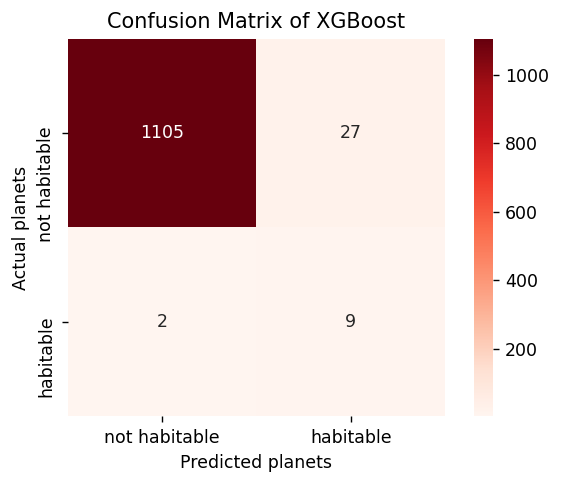

In [60]:
conf_matrix(conf_xg)
plt.title('Confusion Matrix of XGBoost')

In [64]:
# saving model
pickle.dump(xgboost, open("model.pkl","wb"))

***PRAKHAR_VARSHNEY***